# Task 1

In this task, we decided to consider it to be a binary classification problem, i.e. predict if the given player is a dark skin person or a light skin one. We sparated the range of skintone ([0, 1]) equally to get two classes.

## Basic procedures
Import some library classes and data

In [2]:
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Imputer, StandardScaler
from sklearn.model_selection import GridSearchCV, GroupShuffleSplit, ShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score

data = pd.read_csv('CrowdstormingDataJuly1st.csv', quotechar='"')

To produce the feature matrix, we did the following convertions:

1. use the mean of rater1 and rater2 as the target skintone
2. map club, league, position and group columns into integer numbers
3. get ages of players from the column birthday

**Note:** Here we map the playerShort to a categorical variable and get its codes for further use, because we don't want the same player appear in both train and test dataset. The classifier would otherwise match train and test data of the same player, in which case we would see super high accuracy around 99%, which however is not accurate at all. In that case, we are only searching the same person in test dataset rather than predicting. We also prove this below.

In [11]:
def get_numeric_features(data, features, new_feat=None):
    """
    Params:
        features(list): requested feature columns
        
    Return:
        x(list): feature matrix
        y(list): target variable list
        g(list): group code of each player
    """
    # get targe variable  
    mean_rate = (data['rater1'] + data['rater2']) / 2
    data['skintone'] = mean_rate > 0.5
    data['skintone'] = data['skintone'].astype('int')
    # map categorical variables to codes
    data['club'] = data['club'].astype('category').cat.codes
    data['league'] = data['leagueCountry'].astype('category').cat.codes
    data['position'] = data['position'].astype('category').cat.codes
    data['group'] = data['playerShort'].astype('category').cat.codes
    # generate age feature
    data['age'] = 2016 - data['birthday'].str.rsplit('.', 1, True)[1].astype('int')
    
    # add new features
    if new_feat is not None:
        data = pd.concat([data, new_feat], axis=1)

    # choose desired features only
    x_feat = data[features]

    # drop samples without any skintone for classification problem
    valid_y = np.where(~np.isnan(data['skintone']))  
    x = x_feat.loc[valid_y[0]].values.tolist()
    y = data['skintone'][valid_y[0]]
    g = data['group'][valid_y[0]]

    return x, y, g

The following two functions are used to draw a chart showing train and test scores to see overfitting

In [4]:
def draw_cv(train, test, x, x_label):
    plt.plot(x, train, 'b-')
    plt.plot(x, test, 'r-')
    ax = plt.gca()
    ax.set_ylim(top=1.05)
    plt.xlabel(x_label)
    plt.ylabel('error')
    plt.title('visualization')
    plt.show()


def get_train_test_score(res, params):
    res_pd = pd.DataFrame(res)
    temp = res_pd
    for k, v in params.items():
        temp = temp[temp[k] == v]
    train = temp[[col for col in temp.columns 
                  if 'train' in col and 'mean' not in col and 'std' not in col]]
    test = temp[[col for col in temp.columns 
                 if 'test' in col and 'mean' not in col and 'std' not in col and 'rank' not in col]]
    return train.mean(axis=1).tolist(), test.mean(axis=1).tolist()

Build a pipeline to do cross validation to find the best model and paramters. We can also see the train scores and test scores in the meantime.

We first set two paramters of `RandomForestClassifier`, n_estimators and max_features, to be `[i for i in range(1, 10)]` and `['auto', 'sqrt', 'log2']` respectively, and then run the grid search cross validation on the classifier with each pair of the two parameters.

In [5]:
# parameters of RandomForestClassifier to be tested
params={
    'rf__n_estimators': [i for i in range(1, 10)],
    'rf__max_features': ['sqrt', 'log2', None]
}

pipe = Pipeline([
         ('replace', Imputer(strategy='median')),  # replace NaN value with median valuep
         ('standardize', StandardScaler()),  # standardization 
         ('rf', RandomForestClassifier(n_jobs=-1))  # classification
     ])

# feature columns that we want to use
all_features = [
    'league', 'club', 'height', 'weight', 'age', 'position', 
    'games', 'victories', 'ties', 'defeats', 'goals', 
    'yellowCards', 'yellowReds', 'redCards', 
    'refNum', 'refCountry',
    'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp'
]

x, y, groups = get_numeric_features(data, all_features)

**Note:** We first use `ShuffleSplit`, which is supposed to used on i.i.d samples, to show how super accuracy is acquired.

In [14]:
# use GridSearchCV to do the cross valiation to find best parameter set
gs_cv = GridSearchCV(pipe, params, n_jobs=-1,
                    cv=ShuffleSplit(n_splits=20, test_size=0.2, train_size=0.8))
gs_cv.fit(x, y, groups)

GridSearchCV(cv=ShuffleSplit(n_splits=20, random_state=None, test_size=0.2, train_size=0.8),
       error_score='raise',
       estimator=Pipeline(steps=[('replace', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='...mators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'rf__max_features': ['sqrt', 'log2', None], 'rf__n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Then we noticed our samples **are not i.i.d samples**, and thus we choose to group the samples from the same players so as to eliminate such inaccuracy caused by matching the data of the same person.

In [23]:
# use GridSearchCV to do the cross valiation to find best parameter set
gs_cv = GridSearchCV(pipe, params, n_jobs=-1,
                    cv=GroupShuffleSplit(n_splits=20, test_size=0.2, train_size=0.8))
gs_cv.fit(x, y, groups)

GridSearchCV(cv=GroupShuffleSplit(n_splits=20, random_state=None, test_size=0.2,
         train_size=0.8),
       error_score='raise',
       estimator=Pipeline(steps=[('replace', Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)), ('standardize', StandardScaler(copy=True, with_mean=True, with_std=True)), ('rf', RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='...mators=10, n_jobs=-1, oob_score=False, random_state=None,
            verbose=0, warm_start=False))]),
       fit_params={}, iid=True, n_jobs=-1,
       param_grid={'rf__max_features': ['sqrt', 'log2', None], 'rf__n_estimators': [1, 2, 3, 4, 5, 6, 7, 8, 9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score=True,
       scoring=None, verbose=0)

Find the best score and the best parameter pair for the baseline. 

In [24]:
gs_cv.best_score_, gs_cv.best_params_

(0.85447057757225175, {'rf__max_features': 'log2', 'rf__n_estimators': 6})

We use the group of train scores and test scores whose `max_features` is set to `'log2'` and `n_estimators` is set to a range of list to show we are overfitting the dataset. 

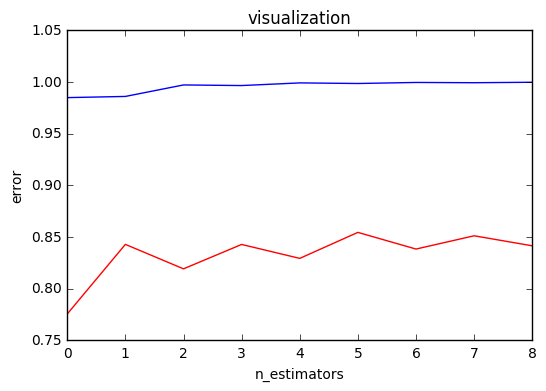

In [25]:
res = gs_cv.cv_results_
train, test = get_train_test_score(res, {'param_rf__max_features': 'log2'})
draw_cv(train, test, [i for i in range(9)], 'n_estimators')

### Add more CV charts to show paramter tuning process

## Drop features
We group current features into 5 groups. Each group is related to the player himself, one game, card numbers, referee and bias test results. We want to see the results of dropping each group of features. 

## Add new features

We can get `totalIAT` by multiplying `meanIAT` and `nIAT`. Since implicit bias score (using the race IAT) represents the bias of a referee, we multiply it with `yellowCards`, `yellowReds`, `redCards` to generate 3 more features. We generate 4 similar features with respect to explicit bias score too. Then run the same procedure.

In [12]:
def generate_new_features(data):
    data['totalIAT'] = data['meanIAT'] * data['nIAT']
    data['yr_IAT'] = data['totalIAT'] * data['yellowReds']
    data['yc_IAT'] = data['totalIAT'] * data['yellowCards']
    data['r_IAT'] = data['totalIAT'] * data['redCards']
    data['totalExp'] = data['meanExp'] * data['nExp']
    data['yr_Exp'] = data['totalExp'] * data['yellowReds']
    data['yc_Exp'] = data['totalExp'] * data['yellowCards']
    data['r_Exp'] = data['totalExp'] * data['redCards']
    return data[['totalIAT', 'yr_IAT', 'yc_IAT', 'r_IAT', 
                 'totalExp', 'yr_Exp', 'yc_Exp', 'r_Exp']]

new_features_added = [
    'league', 'club', 'height', 'weight', 'age', 'position', 
    'games', 'victories', 'ties', 'defeats', 'goals', 
    'yellowCards', 'yellowReds', 'redCards', 
    'refNum', 'refCountry',
    'meanIAT', 'nIAT', 'seIAT', 'meanExp', 'nExp', 'seExp',
    'totalIAT', 'yr_IAT', 'yc_IAT', 'r_IAT', 'totalExp', 'yr_Exp', 'yc_Exp', 'r_Exp'
]
new_x, new_y, new_groups = get_numeric_features(data, new_features_added, generate_new_features(data))

In [ ]:
gs_cv = GridSearchCV(pipe, params, n_jobs=-1,
                    cv=GroupShuffleSplit(n_splits=20, test_size=0.2, train_size=0.8))
gs_cv.fit(new_x, new_y, new_groups)

We didn't see any improvements after adding these four features. The overfitting issue still exists.

In [15]:
gs_cv.best_score_, gs_cv.best_params_

(0.85790223230558915, {'rf__max_features': 'log2', 'rf__n_estimators': 6})

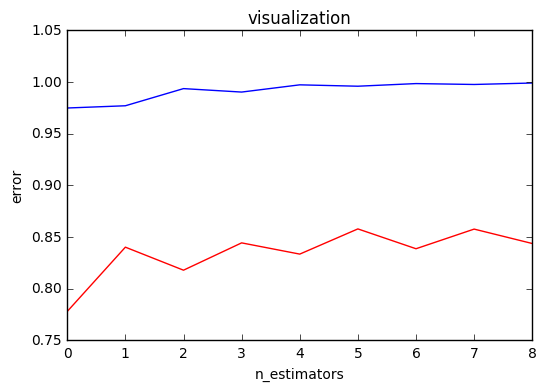

In [16]:
res = gs_cv.cv_results_
train, test = get_train_test_score(res, {'param_rf__max_features': 'log2'})
draw_cv(train, test, [i for i in range(9)], 'n_estimators')